# ARIMA Model Analysis on Microsoft Stock Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = 'Microsoft_Stock.csv'
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

In [2]:
# Extract the closing price series
series = df['Close']

# Perform ADF test to check stationarity
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.737136
p-value: 0.998216


In [3]:
# Plot original series and differencing
plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})



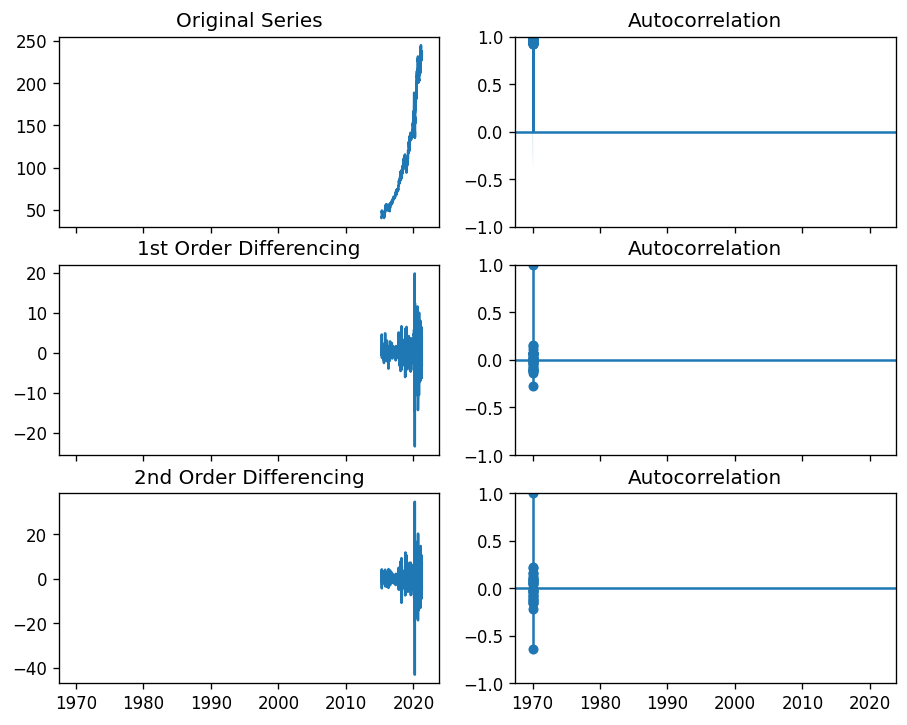

In [4]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(series)
axes[0, 0].set_title('Original Series')
plot_acf(series, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [5]:
# Perform ADF test on 1st differenced series
result = adfuller(series.diff().dropna())
print('ADF Statistic (1st Differencing): %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic (1st Differencing): -10.038331
p-value: 0.000000


In [6]:
# Perform ADF test on 2nd differenced series
result = adfuller(series.diff().diff().dropna())
print('ADF Statistic (2nd Differencing): %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic (2nd Differencing): -15.445536
p-value: 0.000000


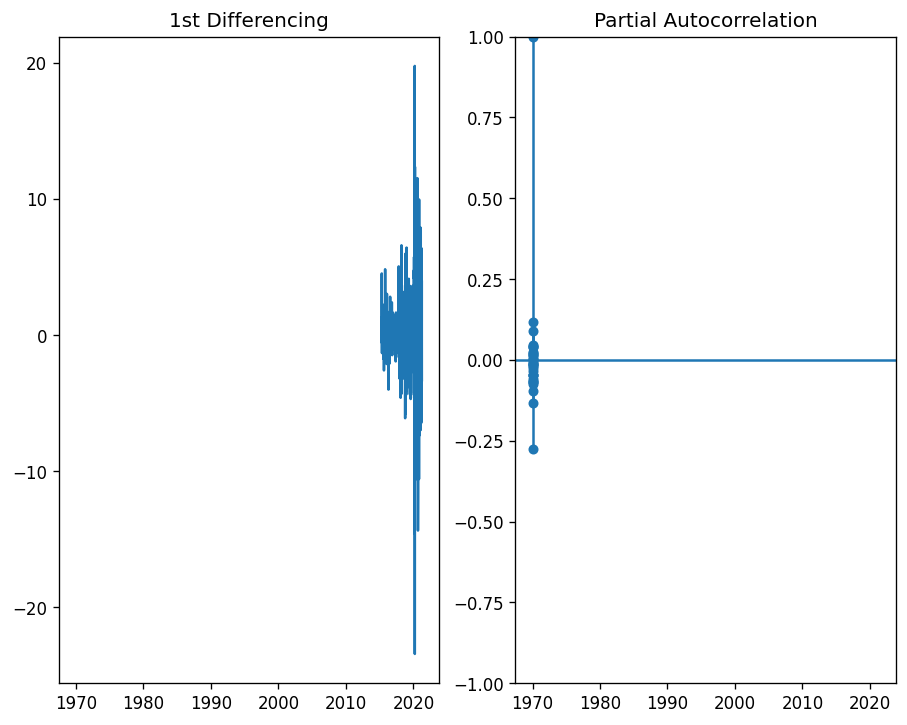

In [7]:
# PACF plot for AR term determination
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(series.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 5))
plot_pacf(series.diff().dropna(), ax=axes[1])
plt.show()

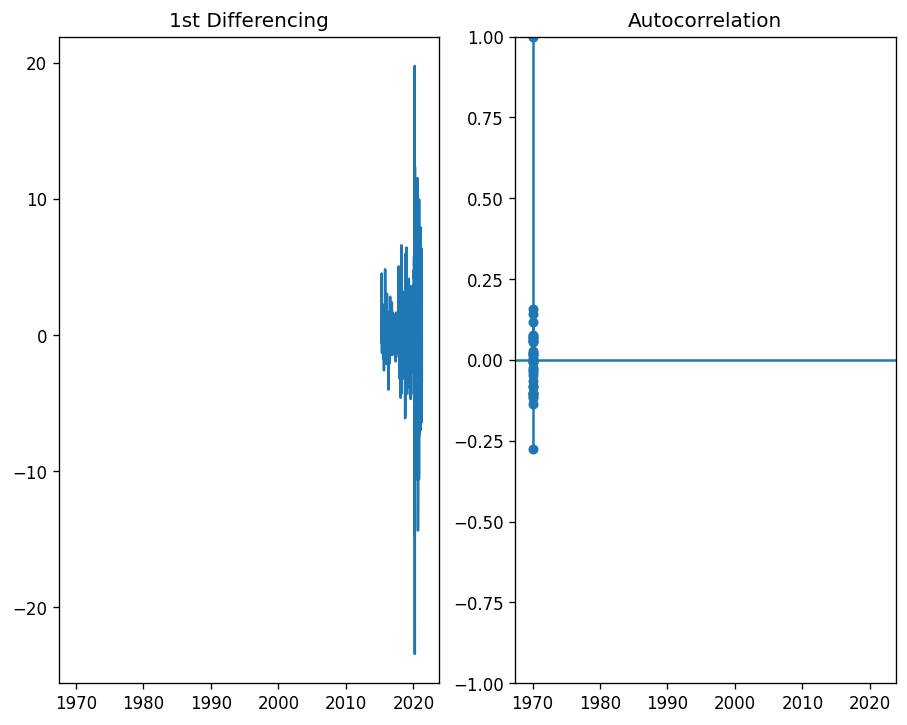

In [8]:
# ACF plot for MA term determination
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(series.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 1.2))
plot_acf(series.diff().dropna(), ax=axes[1])
plt.show()

In [9]:
# Build and fit an ARIMA model manually (using a simpler order)
manual_arima_order = (2, 1, 2)  # Based on previous analysis and differencing results
manual_model = ARIMA(series, order=manual_arima_order)
manual_model_fit = manual_model.fit()
print(manual_model_fit.summary())

c:\Users\Sanjay B\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Sanjay B\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Sanjay B\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3377.962
Date:                Fri, 11 Oct 2024   AIC                           6765.924
Time:                        11:28:51   BIC                           6792.524
Sample:                             0   HQIC                          6775.830
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.144     -0.003      0.997      -0.283       0.282
ar.L2         -0.2010      0.063     -3.199      0.001      -0.324      -0.078
ma.L1         -0.2656      0.146     -1.820      0.0

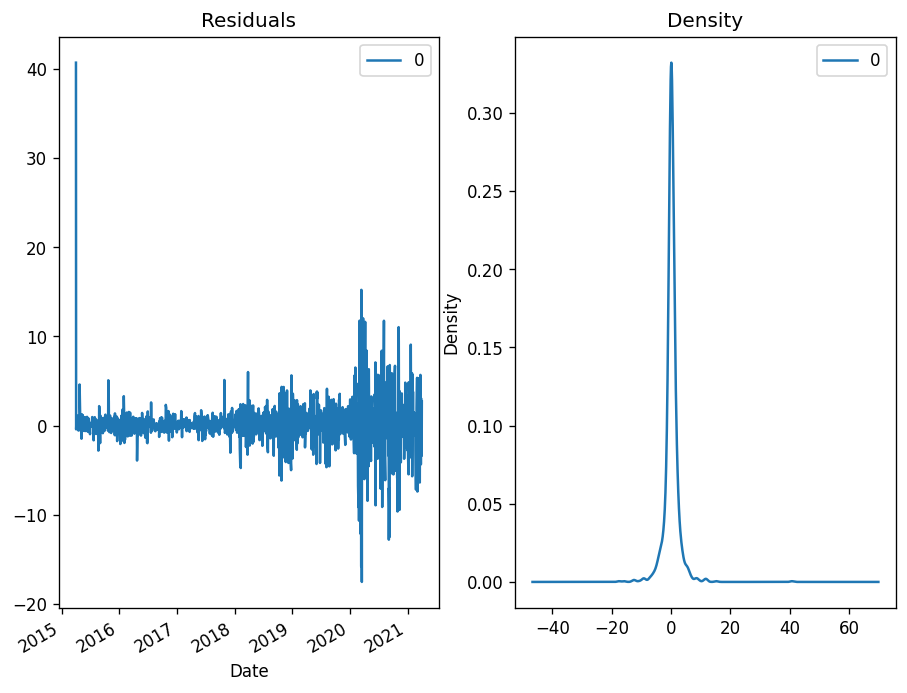

In [10]:
# Plot residual errors
residuals = pd.DataFrame(manual_model_fit.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

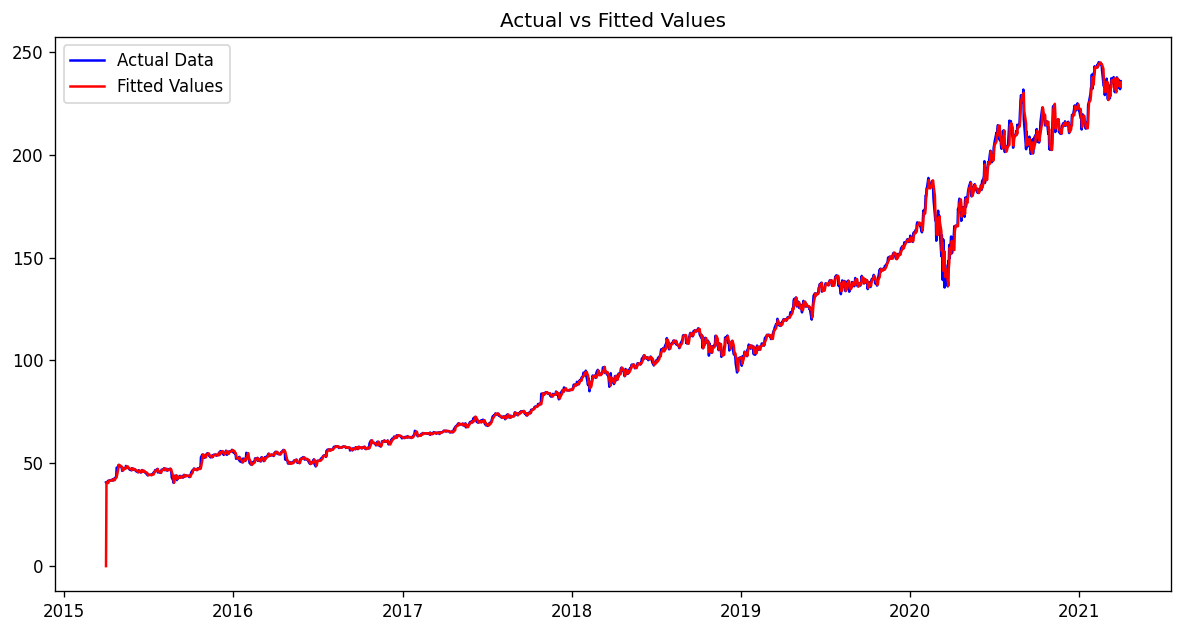

In [11]:
# Manually plot the actual vs fitted values
plt.figure(figsize=(12, 6))
plt.plot(series, label='Actual Data', color='blue')
plt.plot(manual_model_fit.fittedvalues, label='Fitted Values', color='red')
plt.title('Actual vs Fitted Values')
plt.legend()
plt.show()

c:\Users\Sanjay B\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Sanjay B\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


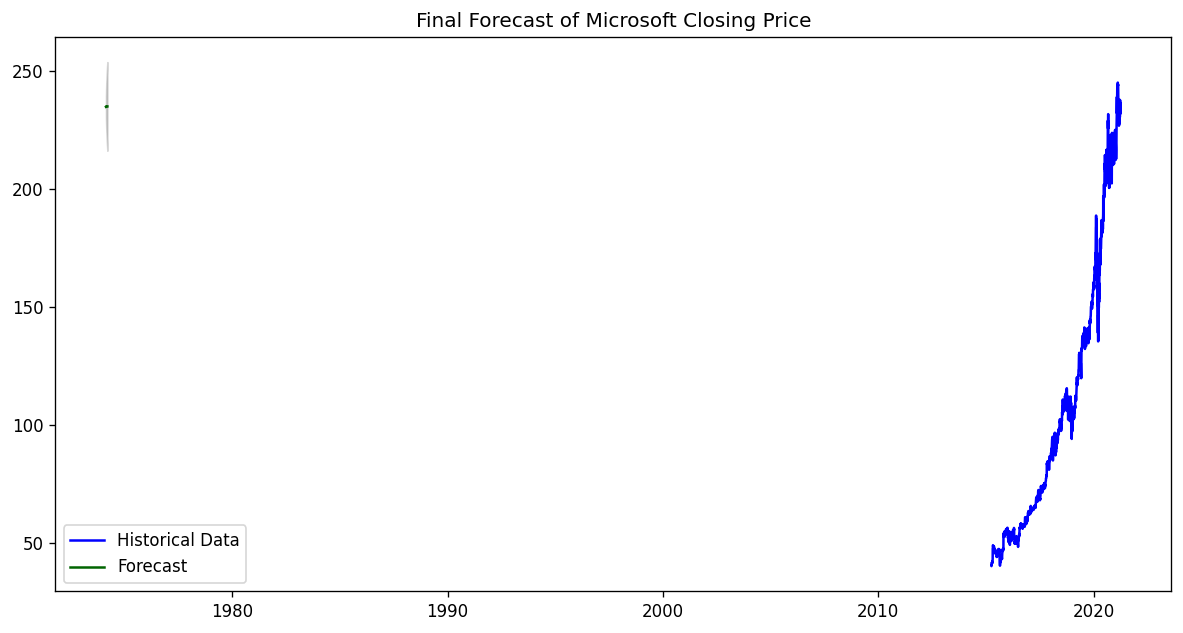

In [12]:
# Forecast using the manually fitted ARIMA model
n_periods = 24
forecast_result = manual_model_fit.get_forecast(steps=n_periods)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

index_of_fc = np.arange(len(series), len(series) + n_periods)

# Make series for plotting
fc_series = pd.Series(forecast.values, index=index_of_fc)
lower_series = pd.Series(conf_int.iloc[:, 0].values, index=index_of_fc)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=index_of_fc)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(series, label='Historical Data', color='blue')
plt.plot(fc_series, color='darkgreen', label='Forecast')
plt.fill_between(fc_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Final Forecast of Microsoft Closing Price")
plt.legend()
plt.show()
    